<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/MCC_VA_Lab1_Equalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
file_name = "img"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

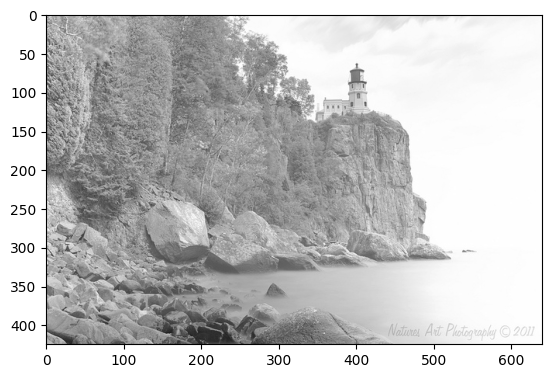

In [4]:
img = cv2.imread(path+file_name+'.jpg',0)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
import os
import subprocess

In [6]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [7]:
!pip install nvcc4jupyter

In [8]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp5fhbqi8d".


In [9]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [10]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>
#include <numeric>
#include <stdlib.h>
#include <stdio.h>

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>

using namespace cv;
using namespace std;

int width;
int height;
bool with_gpu = true;
string file_name = "img";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";


static int eq_GPU(unsigned char *input_ptr);
#define CUDA_CHECK_RETURN(value) CheckCudaErrorAux(__FILE__,__LINE__, #value, value)


//Kernel para la conversión de color RGB a YCbCr y para calcular el histograma del canal Y.
__global__ void RGB_to_YCbCr_kernel(unsigned char *input, int* hist, int width, int height){

	//Cree e inicialice un histograma compartido para disminuir la latencia causada por el acceso a la memoria global.
	__shared__ int hist_priv[256];

	int idx = blockIdx.x*blockDim.x + threadIdx.x;

	long point_index;

	for(int bin_idx = threadIdx.x; bin_idx < 256; bin_idx += blockDim.x){
		hist_priv[bin_idx] = 0;
	}

	__syncthreads();

	//Si no tiene la cantidad requerida de subprocesos, el acceso a la imagen en la memoria global se fusiona.
	//La imagen se guarda en un buffer para facilitar el acceso combinado;
	for(int i = idx; i < width*height; i += blockDim.x*gridDim.x){
		point_index = i*3;
		int r = input[point_index+0];
		int g = input[point_index+1];
		int b = input[point_index+2];

		int Y = (int) (0.299*r + 0.587*g + 0.114*b);
		int Cb = (int) (128 - 0.168736*r - 0.331264*g +0.5*b);
		int Cr = (int) (128 + 0.5*r - 0.418688*g - 0.081312*b);

		input[point_index+0] = Y;
		input[point_index+1] = Cb;
		input[point_index+2] = Cr;

		//Actualizar el histograma compartido.
		atomicAdd(&(hist_priv[Y]), 1);
	}
	__syncthreads();

	//Los histogramas compartidos se agregan al histograma global.
	for(int bin_idx = threadIdx.x; bin_idx < 256; bin_idx += blockDim.x){
		atomicAdd(&(hist[bin_idx]), hist_priv[bin_idx]);
	}
}

//Este kernel iguala el histograma
__global__ void equalize_kernel(int* cdf, int* hist, int width, int height){

	int idx = blockIdx.x*blockDim.x + threadIdx.x;

	for(int i = idx; i < 256; i += blockDim.x*gridDim.x){
		hist[i] = (int) (((((float)cdf[i] - cdf[0]))/(((float)width*height - 1)))*255);
	}
}

// Este kernel asigna los nuevos valores ecualizados del canal Y y
// realiza la conversión de color de YCbCr a RGB.
__global__ void YCbCr_to_RGB_kernel(unsigned char *input, int* hist, int* cdf, int width, int height){

	int idx = blockIdx.x*blockDim.x + threadIdx.x;

	//long index = (row*width + col);
	long point_index;

	for(int i = idx; i < width*height; i += blockDim.x*gridDim.x){

		point_index = i*3;

		int value_before = input[point_index];
		int value_after = hist[value_before];

		//input[point_index] = value_after;

		int y = value_after;
		int cb = input[point_index+1];
		int cr = input[point_index+2];

		int R = max(0, min(255, (int) (y + 1.402*(cr-128))));
		int G = max(0, min(255, (int) (y - 0.344136*(cb-128) - 0.714136*(cr-128))));
		int B = max(0, min(255, (int) (y + 1.772*(cb- 128))));

		input[point_index+0] = R;
		input[point_index+1] = G;
		input[point_index+2] = B;

	}
}

int main(void)
{
	// Cargar la imagen
	cout << "Cargando imagen.." << endl;
	string input_name = path + file_name + ".jpg";
	Mat input = imread(input_name, IMREAD_COLOR); //CV_LOAD_IMAGE_COLOR);

	if(!input.data){
		cout << "Imagen no encontrada!" << endl;
		return -1;
	}

	height = input.rows;
	width = input.cols;

	// Convertir la imagen en un buffer
	unsigned char *input_ptr = input.ptr();

	cout << "Starting to process.." << endl;

	if(with_gpu){
		cout << "Processing with GPU" << endl;
		eq_GPU(input_ptr);
	}

	//Save the image
	cout << "Saving output image.."<< endl;
	string output_name;
	if(with_gpu){
		output_name = path + file_name + "_equalized_gpu.jpg";
	}
	imwrite(output_name, input);
	cout << "Imagen guarda!"<< endl;

	return 0;
}


// Verificar el valor de retorno de la llamada API de tiempo de ejecución de CUDA y salga de la aplicación si la llamada falló.

static void CheckCudaErrorAux (const char *file, unsigned line, const char *statement, cudaError_t err)
{
	if (err == cudaSuccess)
		return;
	std::cerr << statement<<" returned " << cudaGetErrorString(err) << "("<<err<< ") at "<<file<<":"<<line << std::endl;
	exit (1);
}

static int eq_GPU(unsigned char *input_ptr){

	unsigned char *gpu_input;
	int *d_hist;
	int *d_cdf;
	int *d_hist_eq;
	int h_hist[256] = {0};

	// Asignar la memoria global de GPU necesaria.
	CUDA_CHECK_RETURN(cudaMalloc((void **)&gpu_input, sizeof(char)*(width*height*3)));
	CUDA_CHECK_RETURN(cudaMalloc((void **)&d_hist, sizeof(int)*(256)));
	CUDA_CHECK_RETURN(cudaMalloc((void **)&d_hist_eq, sizeof(int)*(256)));
	CUDA_CHECK_RETURN(cudaMalloc((void **)&d_cdf, sizeof(int)*(256)));

	// Copiar el búfer de imagen a la memoria global.
	CUDA_CHECK_RETURN(cudaMemcpy(gpu_input, input_ptr, sizeof(char)*(width*height*3), cudaMemcpyHostToDevice));
	CUDA_CHECK_RETURN(cudaMemcpy(d_hist, h_hist, sizeof(int)*(256), cudaMemcpyHostToDevice));

	int block_size = 256;
	int grid_size = (width*height + (block_size-1))/block_size;

	// Llamar al primer kernel
	RGB_to_YCbCr_kernel<<<grid_size, block_size>>> (gpu_input, d_hist, width, height);

	// Copiar para alojar el histograma calculado en el primer kernel.
	CUDA_CHECK_RETURN(cudaMemcpy(h_hist, d_hist, sizeof(int)*(256), cudaMemcpyDeviceToHost));

	int sum = 0;
	int h_cdf[256] = {0};

	for(int i = 0; i < 256; i++){
		sum += h_hist[i];
		h_cdf[i] = sum;
	}

	CUDA_CHECK_RETURN(cudaMemcpy(d_cdf, h_cdf, sizeof(int)*(256), cudaMemcpyHostToDevice));

	// Llamar al segundo kernel.
	equalize_kernel<<<grid_size, block_size>>> (d_cdf, d_hist_eq, width, height);

	// Llamar al tercer kernel.
	YCbCr_to_RGB_kernel<<<grid_size, block_size>>> (gpu_input, d_hist_eq, d_cdf, width, height);

	// Copiar para alojar la imagen ecualizada.
	CUDA_CHECK_RETURN(cudaMemcpy(input_ptr, gpu_input, sizeof(char)*(width*height*3), cudaMemcpyDeviceToHost));

	// Liberar la memoria de la GPU.
	CUDA_CHECK_RETURN(cudaFree(gpu_input));
	CUDA_CHECK_RETURN(cudaFree(d_hist));
	CUDA_CHECK_RETURN(cudaFree(d_hist_eq));
	CUDA_CHECK_RETURN(cudaFree(d_cdf));

	return 0;
}

Cargando imagen..
Starting to process..
Processing with GPU
Saving output image..
Imagen guarda!



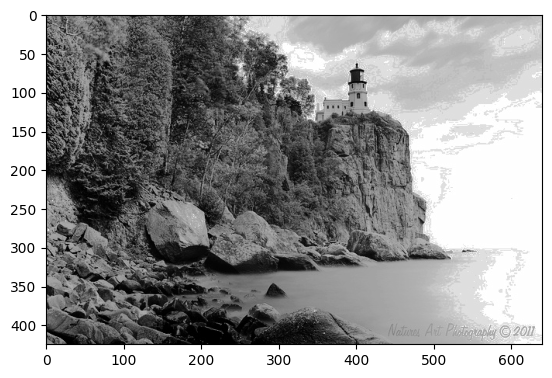

In [11]:
img = cv2.imread(path+file_name+'_equalized_gpu.jpg',0)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [12]:
def escribiendo_resultado(nueva_imagen, img, heigth, width, s_n):
    # Nueva imagen
    for i in range(heigth):
        for j in range(width):
            nueva_imagen[i][j] = int(s_n[img[i][j]])

def calculando_histograma(img, heigth, width, intensidad):
    histograma = np.zeros((intensidad, 1) ,np.float32)

    for i in range(heigth):
        for j in range(width):
            histograma[img[i][j]][0] = histograma[img[i][j]][0] + 1

    return histograma

# Ecualizacion del Histograma
def ecualizacion(heigth, width, s_n, L, histograma):
    p_n = np.zeros(L ,np.float32)
    h_w = heigth*width
    p_n[0] = histograma[0][0]/h_w
    s_n[0] = math.floor((L-1)*p_n[0])

    for i in range(1,L):
        p_n[i] = histograma[i][0]/h_w + p_n[i-1]
        s_n[i] = math.floor((L-1)*p_n[i])


def segmento(f, c, x, y, img, intensidad, s_n, nueva_imagen): #f -> fila c -> columna
    crop_img = img[f:f+y, c:c+x]
    plt.imshow(crop_img, cmap='gray', vmin=0, vmax=255)
    plt.show()
    cv2.imwrite(path+file_name+'_equalized_crop.jpg', crop_img)

    heigth = crop_img.shape[0]
    width = crop_img.shape[1]

    histograma = calculando_histograma(crop_img, heigth, width, intensidad)
    ecualizacion(heigth, width, s_n, intensidad, histograma)

    heigth = img.shape[0]
    width = img.shape[1]
    escribiendo_resultado(nueva_imagen, img, heigth, width, s_n)


425 640


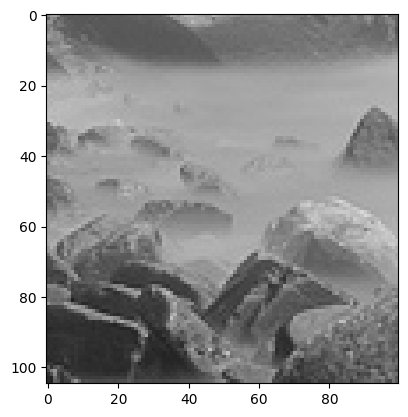

In [13]:
# Leer imagen
img = cv2.imread(path+file_name+'.jpg', cv2.IMREAD_GRAYSCALE)

# Dimensiones de la imagen
heigth = img.shape[0]
width = img.shape[1]

print (heigth, width)

intensidad = 256
# Imagen resultado
nueva_imagen = np.zeros((heigth, width, 1), np.uint8)

s_n = np.zeros(intensidad ,np.float32)

segmento(320, 200, 100, 120, img, intensidad, s_n, nueva_imagen)

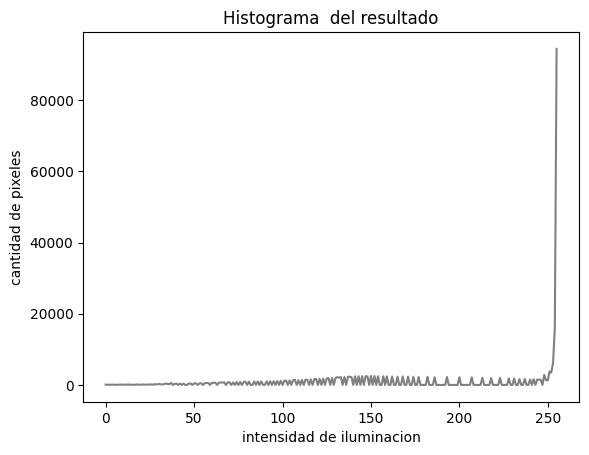

In [14]:
hist = cv2.calcHist([nueva_imagen], [0], None, [256], [0, 256])
plt.plot(hist, color='gray' )
plt.title("Histograma  del resultado")
plt.xlabel('intensidad de iluminacion')
plt.ylabel('cantidad de pixeles')
plt.savefig('hist_segmento.png')
plt.show()

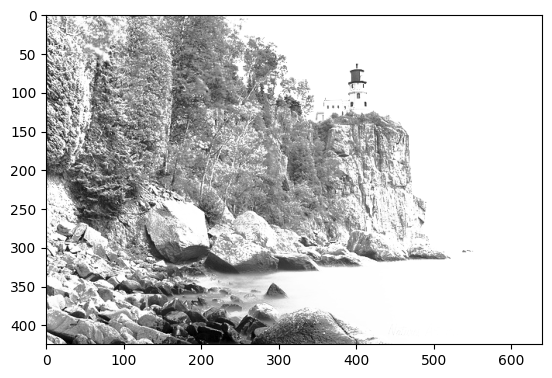

In [15]:
plt.imshow(nueva_imagen, cmap='gray', vmin=0, vmax=255)
plt.show()
cv2.imwrite(path+file_name+'_equalized_python.jpg', nueva_imagen)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
exit()